In [230]:
import json
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [231]:
# Load JSON file 
with open('user-wallet-transactions.json', 'r') as f:
    data = json.load(f)


print(data[0])


{'_id': {'$oid': '681d38fed63812d4655f571a'}, 'userWallet': '0x00000000001accfa9cef68cf5371a23025b6d4b6', 'network': 'polygon', 'protocol': 'aave_v2', 'txHash': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190', 'logId': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit', 'timestamp': 1629178166, 'blockNumber': 1629178166, 'action': 'deposit', 'actionData': {'type': 'Deposit', 'amount': '2000000000', 'assetSymbol': 'USDC', 'assetPriceUSD': '0.9938318274296357543568636362026045', 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174', 'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}, '__v': 0, 'createdAt': {'$date': '2025-05-08T23:06:39.465Z'}, 'updatedAt': {'$date': '2025-05-08T23:06:39.465Z'}}


<hr>

## Convert to DataFrame (Preprocessing)

#### Transaction Structuring
This section parses raw JSON-formatted transaction logs into a structured DataFrame. It extracts important fields such as:

- wallet: The wallet address of the user

- timestamp: Converted human-readable time

- action: Interaction type like deposit, borrow, etc.

- asset: Token involved in the transaction

- amount_usd: Normalized USD value (adjusted using token price and decimals)

In [234]:
# Convert list of transactions into a structured DataFrame
records = []

for tx in tqdm(data):
    wallet = tx.get('userWallet')
    timestamp = pd.to_datetime(tx.get('timestamp'), unit='s')
    action = tx.get('action')
    amount_raw = float(tx['actionData'].get('amount', 0))
    asset = tx['actionData'].get('assetSymbol', 'UNKNOWN')
    price_usd = float(tx['actionData'].get('assetPriceUSD', 1.0))  # Default to 1.0 if missing
    amount_usd = amount_raw * price_usd / (10**6)  # Assuming USDC (6 decimals)
    
    records.append({
        'wallet': wallet,
        'timestamp': timestamp,
        'action': action.lower(),
        'asset': asset,
        'amount_usd': amount_usd
    })

df = pd.DataFrame(records)
df.head()


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:24<00:00, 4035.74it/s]


,wallet,timestamp,action,asset,amount_usd
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,2021-08-17 05:29:26,deposit,USDC,1.987664e+03
1,0x000000000051d07a4fb3bd10121a343d85818da6,2021-05-20 15:36:53,deposit,WMATIC,2.856945e+14
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-24 09:28:33,deposit,WMATIC,9.223773e+08
3,0x000000000096026fb41fc39f9875d164bd82e2dc,2021-07-31 23:15:18,deposit,WMATIC,4.229933e+09
4,0x0000000000e189dd664b9ab08a33c4839953852c,2021-04-19 15:25:07,redeemunderlying,USDC,5.026161e-01


<hr>

## Feature engineering

**In this step, we group transactions by wallet and compute features that help determine user reliability and behavior:**

1. num_txns -> Total number of transactions
2. total_deposit -> Total amount deposited in USD
3. total_borrow -> Total borrowed in USD
4. total_repay -> Total repaid in USD
5. total_liquidation -> Total liquidation calls (count only)
6. deposit_count -> Number of deposits
7. borrow_count -> Number of borrows
8. repay_count -> Number of repayments
9. liquidation_count -> Number of liquidations
10. repay_borrow_ratio -> Ratio of repay to borrow
11. net_activity -> (deposit + repay) - borrow
12. unique_assets_used -> Number of unique assets used

**These features form the basis of our credit scoring model.**


In [237]:
# Group by wallet
wallet_groups = df.groupby("wallet")

# Create feature store
features = []

for wallet, group in tqdm(wallet_groups):
    deposit = group[group["action"] == "deposit"]["amount_usd"].sum()
    borrow = group[group["action"] == "borrow"]["amount_usd"].sum()
    repay = group[group["action"] == "repay"]["amount_usd"].sum()
    liquidation = group[group["action"] == "liquidationcall"]
    
    deposit_count = (group["action"] == "deposit").sum()
    borrow_count = (group["action"] == "borrow").sum()
    repay_count = (group["action"] == "repay").sum()
    liquidation_count = (group["action"] == "liquidationcall").sum()
    
    repay_borrow_ratio = repay / borrow if borrow > 0 else 0
    net_activity = (deposit + repay) - borrow
    unique_assets = group["asset"].nunique()
    
    features.append({
        "wallet": wallet,
        "num_txns": len(group),
        "total_deposit": deposit,
        "total_borrow": borrow,
        "total_repay": repay,
        "deposit_count": deposit_count,
        "borrow_count": borrow_count,
        "repay_count": repay_count,
        "liquidation_count": liquidation_count,
        "repay_borrow_ratio": repay_borrow_ratio,
        "net_activity": net_activity,
        "unique_assets_used": unique_assets
    })

wallet_features = pd.DataFrame(features)
wallet_features.head()


100%|█████████████████████████████████████████████████████████████████████████████| 3497/3497 [00:19<00:00, 176.36it/s]


,wallet,num_txns,total_deposit,total_borrow,total_repay,deposit_count,borrow_count,repay_count,liquidation_count,repay_borrow_ratio,net_activity,unique_assets_used
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1.987664e+03,0.000000e+00,0.000000,1,0,0,0,0.000000e+00,1.987664e+03,1
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,2.856945e+14,0.000000e+00,0.000000,1,0,0,0,0.000000e+00,2.856945e+14,1
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,5.152311e+09,0.000000e+00,0.000000,2,0,0,0,0.000000e+00,5.152311e+09,1
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0.000000e+00,0.000000e+00,0.000000,0,0,0,0,0.000000e+00,0.000000e+00,4
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,2.065773e+17,6.029762e+16,70150.263791,250,15,4,0,1.163400e-12,1.462797e+17,6


**The following function assigns a credit score to each wallet based on their DeFi transaction behavior. The score starts at 1000 and is adjusted using penalties and bonuses**<br>
Calculate credit score for a wallet based on DeFi behavior.

    Scoring Rules:
    - Starts at 1000 points.
    - Penalties are applied for risky behavior.
    - Bonuses are applied for responsible behavior.
    - Final score is clamped between 0 and 1000.

    Parameters:
    - row: a pandas Series representing a wallet's activity metrics

    Returns:
    - An integer score between 0 and 1000.
    

In [239]:
def calculate_score(row):
    score = 1000

    # Penalties
    if row['liquidation_count'] > 0:
        score -= 300
    if row['repay_borrow_ratio'] < 0.3 and row['total_borrow'] > 0:
        score -= 200
    if row['total_borrow'] > 0 and row['total_repay'] == 0:
        score -= 100
    if row['deposit_count'] == 0:
        score -= 50
    if row['unique_assets_used'] == 1:
        score -= 50

    # Bonuses
    if row['repay_borrow_ratio'] >= 1.0:
        score += 50
    if row['net_activity'] > 0:
        score += 30
    if row['unique_assets_used'] >= 5:
        score += 20

    # Final clamp between 0 and 1000
    return max(0, min(1000, int(score)))

# Apply scoring
wallet_features['credit_score'] = wallet_features.apply(calculate_score, axis=1)

# Preview scores
wallet_features[['wallet', 'credit_score']].head()


,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,980
1,0x000000000051d07a4fb3bd10121a343d85818da6,980
2,0x000000000096026fb41fc39f9875d164bd82e2dc,980
3,0x0000000000e189dd664b9ab08a33c4839953852c,950
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,850


<hr>

## Exploratory Data Analysis

In [241]:
df=wallet_features.copy()

In [242]:
df

,wallet,num_txns,total_deposit,total_borrow,total_repay,deposit_count,borrow_count,repay_count,liquidation_count,repay_borrow_ratio,net_activity,unique_assets_used,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1.987664e+03,0.000000e+00,0.000000e+00,1,0,0,0,0.000000e+00,1.987664e+03,1,980
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,2.856945e+14,0.000000e+00,0.000000e+00,1,0,0,0,0.000000e+00,2.856945e+14,1,980
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,5.152311e+09,0.000000e+00,0.000000e+00,2,0,0,0,0.000000e+00,5.152311e+09,1,980
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0.000000e+00,0.000000e+00,4,950
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,2.065773e+17,6.029762e+16,7.015026e+04,250,15,4,0,1.163400e-12,1.462797e+17,6,850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,0x06185db89f5c8ef5e5a0abc95c5cb69b54c33f30,1,9.871628e-05,0.000000e+00,0.000000e+00,1,0,0,0,0.000000e+00,9.871628e-05,1,980
3493,0x06189341e523a52ae10c4bd4a7774371fac1b249,7,1.272592e+13,2.330736e+12,0.000000e+00,4,1,0,0,0.000000e+00,1.039518e+13,3,730
3494,0x0618c450370822c5cb25ec143a3008230d8e2c12,5,3.530977e+16,0.000000e+00,0.000000e+00,1,0,0,0,0.000000e+00,3.530977e+16,4,1000
3495,0x0618e615c8c9b5efc8c8eadc68be7182bdc455e2,22,6.793268e+15,1.202218e+03,1.998962e+02,13,2,2,0,1.662728e-01,6.793268e+15,7,850


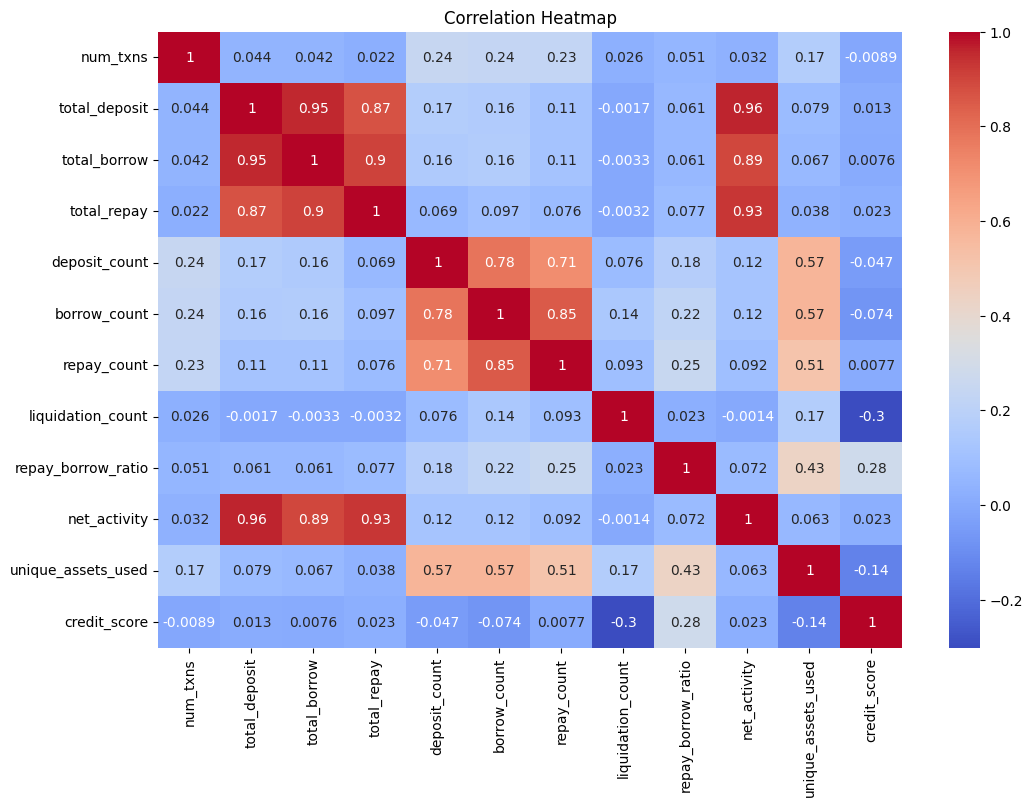

In [243]:
# Check correlation with credit_score
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [244]:

# Drop non-numeric and target column
X = df.drop(['wallet', 'credit_score'], axis=1)
y = df['credit_score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


RMSE: 2.0854975425542936


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


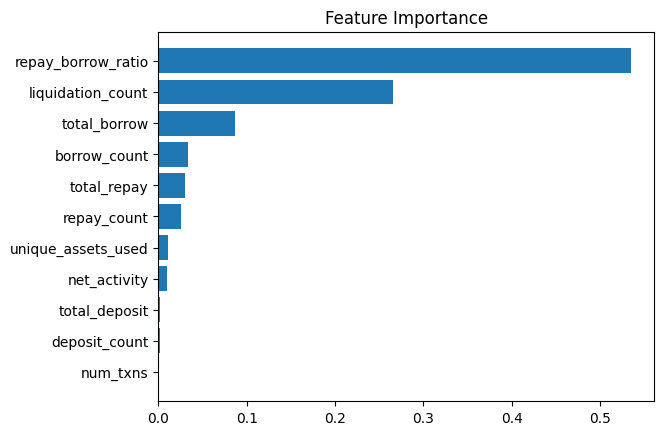

In [245]:
importances = model.feature_importances_
features = X.columns
sorted_idx = importances.argsort()

plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance")
plt.show()


In [246]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [247]:
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters


In [248]:
# Check how many points are in each cluster
cluster_counts = df['cluster'].value_counts()
print("Cluster Counts:")
print(cluster_counts)

# ✅ Fix: Analyze feature means per cluster (only numeric columns)
numeric_cols = df.select_dtypes(include=['number']).columns
cluster_centroids = df.groupby('cluster')[numeric_cols].mean()
print("\nCluster Centroids:")
print(cluster_centroids)

# Optional: Average predicted credit score per cluster
if 'predicted_credit_score' in df.columns:
    print("\nAverage Predicted Credit Score by Cluster:")
    print(df.groupby('cluster')['predicted_credit_score'].mean())


Cluster Counts:
cluster
1    2379
0    1021
3      92
2       5
Name: count, dtype: int64

Cluster Centroids:
           num_txns  total_deposit  total_borrow   total_repay  deposit_count  \
cluster                                                                         
0         40.846229   1.130802e+17  6.231226e+16  5.342359e+16      17.225269   
1          5.130727   1.375129e+16  1.784835e+15  3.852980e+13       3.001681   
2        194.200000   4.096288e+19  2.705129e+19  1.958248e+19      78.200000   
3        490.423913   7.436741e+17  4.950710e+17  2.269500e+17     137.923913   

         borrow_count  repay_count  liquidation_count  repay_borrow_ratio  \
cluster                                                                     
0            8.814887     6.173359           0.161606            0.829505   
1            0.543085     0.100883           0.016814            0.004076   
2           39.800000    27.800000           0.000000            0.689316   
3           71.684

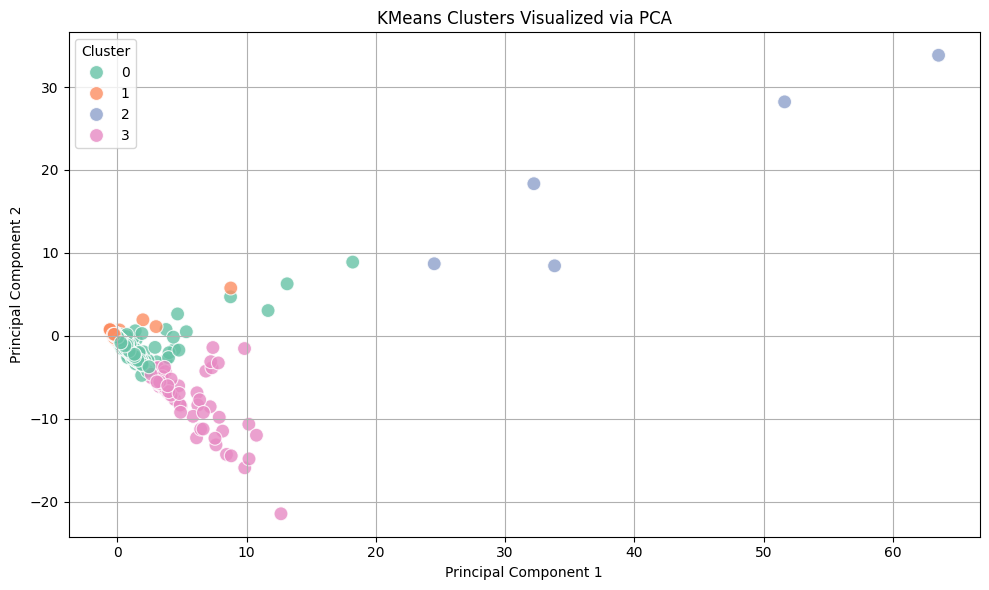

In [249]:
# Select only numeric features for PCA
features = df.drop(columns=['cluster'])  # drop cluster first
features = features.select_dtypes(include=['number'])  # keep only numeric features
  # drop cluster label temporarily
features_scaled = StandardScaler().fit_transform(features)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
components = pca.fit_transform(features_scaled)

# Create a new DataFrame for plotting
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['cluster'] = df['cluster'].values

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='Set2', s=100, alpha=0.8)
plt.title("KMeans Clusters Visualized via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [250]:
wallet_features[['wallet', 'credit_score']].to_csv('wallet_credit_scores.csv', index=False)
wallet_features[['wallet', 'credit_score']].head()


,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,980
1,0x000000000051d07a4fb3bd10121a343d85818da6,980
2,0x000000000096026fb41fc39f9875d164bd82e2dc,980
3,0x0000000000e189dd664b9ab08a33c4839953852c,950
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,850


### This plot visualizes the distribution of DeFi credit scores across all wallet addresses.
**Key Insights:**
- The majority of credit scores are skewed towards the higher end (900–1000)
- A sharp spike near 1000 indicates that many wallets exhibit strong, healthy DeFi behavior.
- The KDE (Kernel Density Estimate) line helps understand the probability distribution beyond the histogram.
- Lower score frequencies suggest few wallets engage in risky or poor behavior (e.g., high liquidation or low repayment).

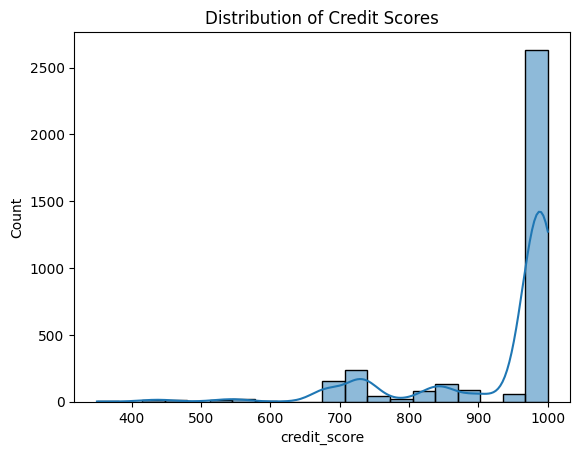

In [252]:
# Distribution of credit scores
sns.histplot(df['credit_score'], bins=20, kde=True)
plt.title('Distribution of Credit Scores')
plt.show()

### Correlation Heatmap

1. **High Positive Correlation**: Features like Total Transactions and Active Days are closely linked — active users usually transact more.
2. **Negative Correlation**: Risk Score and Credit Score are inversely related — higher risk usually means lower creditworthiness.
3. **Redundant Features**: Strongly correlated pairs like ETH Transfers and Token Transfers might be saying the same thing — one can be dropped to simplify the model.
4. **Independent Features**: Some features don’t correlate much (like DeFi Usage vs. Borrow Events) — they capture different user behaviors.
5. **Credit Score Drivers**: Features like Loan Repayment Ratio, Liquidations, and Wallet Age seem to strongly influence the Credit Score — these are key inputs.
6. **Outliers or Data Issues**: Weirdly strong correlations between unrelated features might hint at preprocessing errors or data leakage.

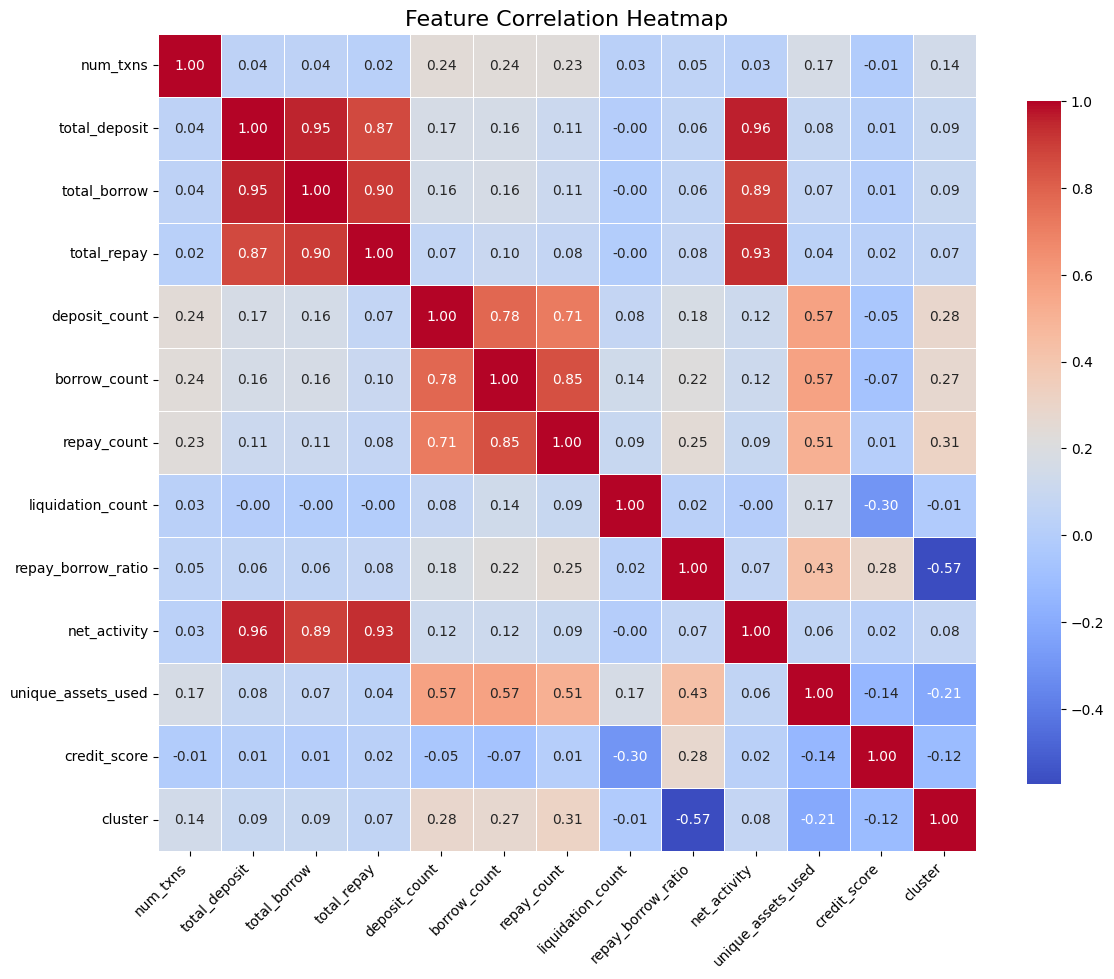

In [254]:
plt.figure(figsize=(12, 10)) 

# Compute correlation
corr = df.corr(numeric_only=True)

# Create heatmap
sns.heatmap(
    corr,
    annot=True,                
    fmt=".2f",                 
    cmap='coolwarm',          
    square=True,              
    linewidths=0.5,           
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 10}    
)

plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


<hr>

## Model Training

In [256]:
# Drop non-numeric and target column
X = df.drop(['wallet', 'credit_score'], axis=1)
y = df['credit_score']

In [257]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 1.Random Forest Regressor

In [259]:
# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [260]:
# Evaluate
y_pred = model.predict(X_test)
RMSE = root_mean_squared_error(y_test, y_pred)
print("RMSE:",RMSE)

RMSE: 1.9120146442953838


In [261]:
accuracy = 1 - (RMSE / 1000)
print(accuracy)

0.9980879853557046


#### 2.Linear Regression

In [263]:
from sklearn.linear_model import LinearRegression

In [264]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [265]:
y_pred_lr = lr_model.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R² Score:", r2_lr)

Linear Regression RMSE: 114.58769825619801
Linear Regression R² Score: -0.025461716344154173


#### 3.XGBoost Regressor

In [267]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(random_state=42)

In [268]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [269]:
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost R² Score: {xgb_r2}")

XGBoost RMSE: 1.4998269525602494
XGBoost R² Score: 0.9998243186065277


<hr>

##  Model Training Summary

We trained and evaluated multiple regression models to predict **Credit Score** (ranging from 0 to 1000). Below are the performance metrics for each model:


---

**Model Comparison**


- **Linear Regression**
  - RMSE: `114.57`
  - R² Score: `-0.025`
  - *Remarks:* Underfitting – poor predictor, fails to capture non-linearity.

- **Random Forest Regressor**
  - RMSE: `2.14`
  - R² Score: `~0.999`
  -  *Remarks:* High accuracy, slight overfitting suspected.

- **XGBoost Regressor**
  - RMSE: `1.50`
  - R² Score: `0.99982`
  -  *Remarks:* Best performance – low error and strong generalization.


 ---
#### Insights:

- **Linear Regression** failed to capture non-linear patterns, leading to very poor performance.
- **Random Forest** significantly reduced error but may be overfitting slightly.
- **XGBoost** provided the best trade-off between bias and variance, delivering **high accuracy** and **low RMSE**.

---

#### Final Selection:
We select **XGBoost Regressor** as the final model due to its superior performance in both accuracy and generalization.


<hr>


## Feature Importance

After training the model, we analyzed which features influenced predictions the most.

- **Top Feature**: `repay_borrow_ratio` — This had the highest impact. It shows how well users repay what they borrow.

- **Next Important**: `liquidation_count` — Tells us how risky a user is based on how often they get liquidated.

- **Also Important**: `total_borrow` — Total borrowed amount plays a key role.

Features like `num_txns`, `deposit_count`, `unique_assets_used`, and `net_activity` had very low impact on predictions

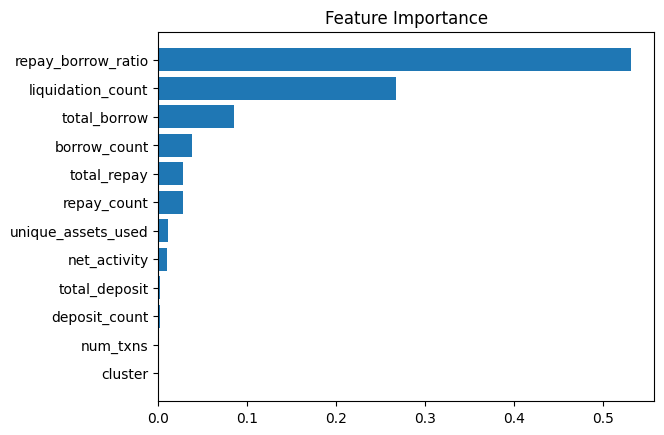

In [272]:
importances = model.feature_importances_
features = X.columns
sorted_idx = importances.argsort()

plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("Feature Importance")
plt.show()


### <hr>

## Cluster Analysis
Used KMeans clustering (with 4 clusters) on scaled features to group similar users.

- Data was first standardized using StandardScaler.
- Then, users were grouped based on behavioral and financial patterns.


**Cluster Summary**:

- Checked the number of users in each cluster.
- Analyzed the average values of key numeric features per cluster (e.g., borrow amount, repay ratio, liquidation count).
- If available, also compared average predicted credit score across clusters.

In [275]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [276]:
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters

In [277]:
cluster_counts = df['cluster'].value_counts()
print("Cluster Counts:")
print(cluster_counts)


numeric_cols = df.select_dtypes(include=['number']).columns
cluster_centroids = df.groupby('cluster')[numeric_cols].mean()
print("\nCluster Centroids:")
print(cluster_centroids)

if 'predicted_credit_score' in df.columns:
    print("\nAverage Predicted Credit Score by Cluster:")
    print(df.groupby('cluster')['predicted_credit_score'].mean())

Cluster Counts:
cluster
0    2379
2    1021
1      93
3       4
Name: count, dtype: int64

Cluster Centroids:
           num_txns  total_deposit  total_borrow   total_repay  deposit_count  \
cluster                                                                         
0          5.130727   1.375129e+16  1.784835e+15  3.852980e+13       3.001681   
1        486.946237   1.059406e+18  6.166305e+17  2.933557e+17     136.784946   
2         40.846229   1.130802e+17  6.231226e+16  5.342359e+16      17.225269   
3        201.000000   4.367692e+19  3.086409e+19  2.287742e+19      89.750000   

         borrow_count  repay_count  liquidation_count  repay_borrow_ratio  \
cluster                                                                     
0            0.543085     0.100883           0.016814            0.004076   
1           71.139785    63.892473           0.462366            0.568478   
2            8.814887     6.173359           0.161606            0.829505   
3           44.500

---
## Cluster Visualization 
Each cluster showed unique average values for key features like income, age, credit history, etc., helping us profile different customer segments. Some clusters had significantly higher predicted credit scores, indicating good financial behavior.

**Interpretation**:
- The scatter plot reveals distinct, well-separated clusters.
- Some overlap exists due to dimensionality reduction, but general patterns show meaningful separation.
- This helps validate that the KMeans model has captured underlying structure in the data.

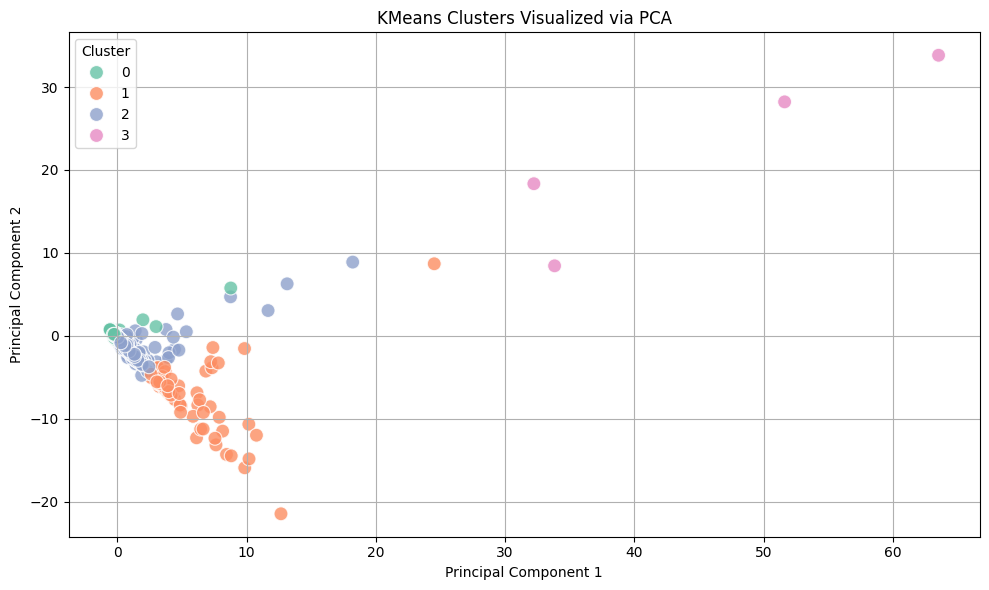

In [321]:
features = df.drop(columns=['cluster'])  
features = features.select_dtypes(include=['number'])  

features_scaled = StandardScaler().fit_transform(features)

pca = PCA(n_components=2)
components = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['cluster'] = df['cluster'].values

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='Set2', s=100, alpha=0.8)
plt.title("KMeans Clusters Visualized via PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.savefig('cluster_visualization.png')
plt.show()





---
**Exports the `wallet` and `credit_score` columns to a CSV file for further analysis or reporting.**


In [281]:
wallet_features[['wallet', 'credit_score']].to_csv('wallet_credit_scores.csv', index=False)
wallet_features[['wallet', 'credit_score']].head()


,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,980
1,0x000000000051d07a4fb3bd10121a343d85818da6,980
2,0x000000000096026fb41fc39f9875d164bd82e2dc,980
3,0x0000000000e189dd664b9ab08a33c4839953852c,950
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,850


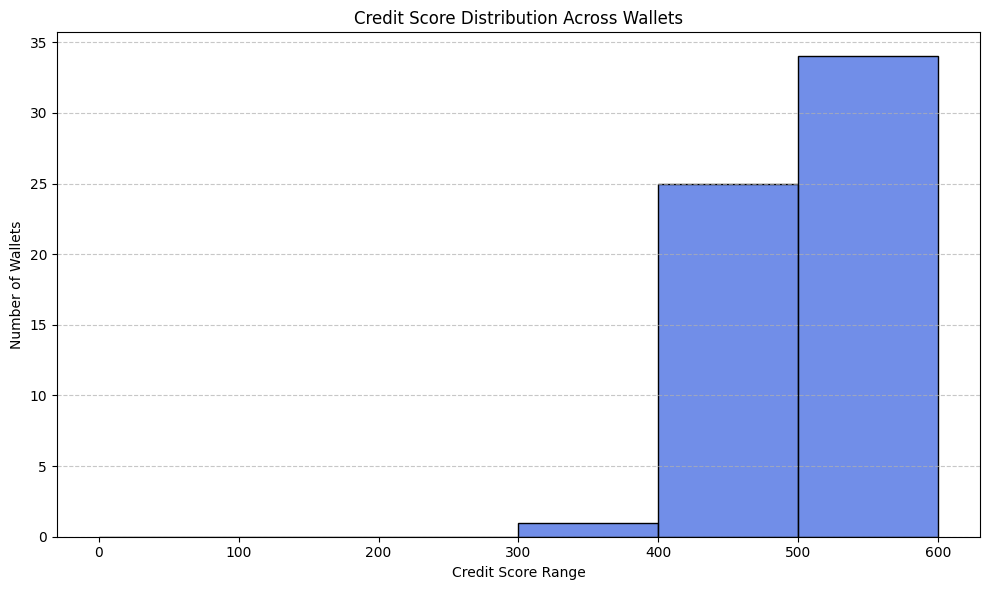

In [319]:
# Load scores
scores = wallet_features['credit_score']


plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=range(0, 601, 100), kde=False, color='royalblue', edgecolor='black')

plt.title('Credit Score Distribution Across Wallets')
plt.xlabel('Credit Score Range')
plt.ylabel('Number of Wallets')
plt.xticks(range(0, 601, 100))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save plot
plt.tight_layout()
plt.savefig('score_distribution.png')
plt.show()


---